# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete SSM.

In [17]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [18]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian
using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

# Generative Model

In [19]:
fg = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

@RV x_0 ~ Categorical(placeholder(:D_s, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

x_k_min = x_0
for k=1:2
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k])
    placeholder(u[k], :u, index=k, dims=(8,8))
    @RV y[k] ~ DiscreteObservation{Generalized}(x[k], A, # Choose Generalized or Bethe constraint
                   placeholder(:C, dims=(16,), var_id=:C_*k),
                   n_factors=8)
    
    x_k_min = x[k] # For next slice
end
;

# Algorithm

In [20]:
q = PosteriorFactorization(y, [x_0; x], A, ids=[:Y, :X, :A])
algo = messagePassingAlgorithm(q, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
initX() = Array{Message}(undef, 9) # Predefine
eval(Meta.parse(code)) # Overwrites initX for Generalized constraint
;

In [21]:
# println(code)

## Action-Perception Loop

In [22]:
α = 0.9; c = 2.0 # Reward probability and utility
S = 20 # Number of trials
R = 100 # Number of runs
seed = 1234 # Randomizer seed

include("helpers.jl")
include("environment.jl")
include("agent.jl")
include("visualizations.jl")

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D

wins = [Vector{Float64}(undef, S) for ri=1:R]

@showprogress for ri=1:R
    rs = generateGoalSequence(S) # Returns random goal sequence
    (reset, execute, observe) = initializeWorld(A, B, C, D, rs) # Let there be a world
    (infer, act) = initializeAgent(A_0, B, C, D_0) # Let there be a constrained agent

    # Step through the experimental protocol
    As = Vector{Matrix}(undef, S) # Posterior statistics for A
    Gs = [Vector{Matrix}(undef, 3) for si=1:S] # Free energy values per time
    as = [Vector{Int64}(undef, 2) for si=1:S] # Actions per time
    os = [Vector{Vector}(undef, 2) for si=1:S] # Observations (one-hot) per time
    for si = 1:S # Simulations start at s=0
        reset(si) # Reset world
        for ti=1:2 # Time starts at t=0
            (Gs[si][ti], _) = infer(ti-1, as[si], os[si])
                as[si][ti] = act(ti-1, Gs[si][ti])
                            execute(as[si][ti])
                os[si][ti] = observe()
        end
        (Gs[si][3], As[si]) = infer(2, as[si], os[si]) # Learn at t=2
    end
    wins[ri] = extractWins(os)
end
;

Progress: 100%|█████████████████████████████████████████| Time: 0:55:34


In [23]:
using FileIO, JLD2
FileIO.save("figures/wins.jld2","wins",wins,"R",R,"S",S)

# Results

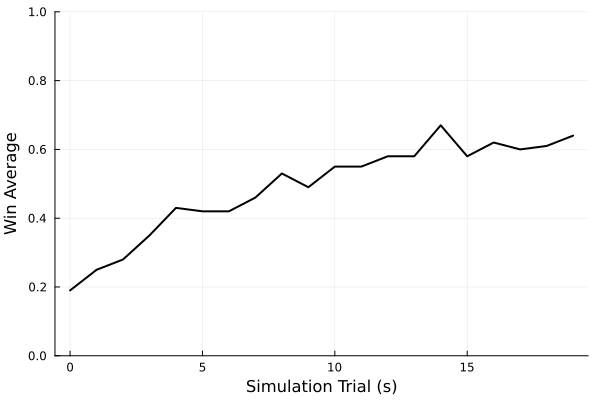

In [28]:
ms = mean(wins)
sds = sqrt.(var(wins))

plot(0:S-1, ms, ylim=(0,1), 
     color=:black, 
     lw=2, 
     legend=false, 
     xlabel="Simulation Trial (s)", 
     ylabel="Win Average")

# savefig("figures/GFE_wins.png")